# OilyGiant Oil Well Development Project

**Objective:**  
Identify the most profitable region for new oil well development by combining machine learning predictions with financial risk analysis.  

**Approach:**  
- Collected and prepared geological data from three regions  
- Trained and evaluated linear regression models to predict oil reserves  
- Applied profit calculations under budget constraints  
- Used bootstrapping (1,000 iterations) to estimate confidence intervals and risk of losses  
- Recommended the optimal region based on maximum profit with <2.5% loss probability  

**Outcome:**  
Region 1 was identified as the best candidate, offering the highest expected profit while staying within the acceptable risk threshold.

In [14]:
## imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
## load Datasets
data_0 = pd.read_csv('data/geo_data_0.csv')
data_1 = pd.read_csv('data/geo_data_1.csv')
data_2 = pd.read_csv('data/geo_data_2.csv')

datasets = [data_0, data_1, data_2]
# Inspect data
for i, data in enumerate(datasets):  # i used enumricate so list of data sets can be interprited as a number
    print(f"Region {i} info:")
    print(data.info())
    print(data.describe())

Region 0 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.3623

## Step 1: Data Inspection Summary

- All three regions have 100,000 wells with complete data.  
- Average reserves: Region 0 ~92.5, Region 1 ~68.8, Region 2 ~95 thousand barrels.  
- Feature ranges differ, which may affect predictions and profits.  
- Data is clean and ready for modeling.

In [16]:
# Step 2: Train and Test Models
models = []
predictions = []

for i, data in enumerate(datasets):
    features = data[['f0', 'f1', 'f2']]
    target = data['product']

    # Split data into 75% train and 25% validation
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.25, random_state=42)

    # Train linear regression model
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Predict on validation set
    target_pred = model.predict(features_val)

    # Evaluate model
    mse = mean_squared_error(target_val, target_pred)
    rmse = np.sqrt(mse)
    print(f"Region {i}: Average predicted volume: {np.mean(target_pred):.2f}, RMSE: {rmse:.2f}")

    # Save model and predictions
    models.append(model)
    predictions.append((target_val, target_pred))


Region 0: Average predicted volume: 92.40, RMSE: 37.76
Region 1: Average predicted volume: 68.71, RMSE: 0.89
Region 2: Average predicted volume: 94.77, RMSE: 40.15


## Model Results Summary

- All regions predicted averages match the actual reserves closely.  
- RMSE is lowest for Region 1 (0.9), higher for Regions 0 and 2 (38-40).  

In [17]:
# Step 3: Prepare for Profit Calculation

# Business conditions
budget = 100000000  # USD
wells_to_develop = 200
revenue_per_thousand_barrel = 4500

# Calculate breakeven volume per well
breakeven_volume_per_well = budget / (wells_to_develop * revenue_per_thousand_barrel)
print(f"Breakeven volume per well: {breakeven_volume_per_well:.2f} thousand barrels")

# Store results in a dictionary
region_stats = {}

# Compare with average predicted reserves for each region
for i, (target_val, target_pred) in enumerate(predictions):
    avg_predicted = np.mean(target_pred)
    region_stats[f"Region {i}"] = {
        "average_predicted": avg_predicted,
        "breakeven_per_well": breakeven_volume_per_well
    }

# Display dictionary
for region, stats in region_stats.items():
    print(f"{region}: {stats}")

Breakeven volume per well: 111.11 thousand barrels
Region 0: {'average_predicted': np.float64(92.39879990657768), 'breakeven_per_well': 111.11111111111111}
Region 1: {'average_predicted': np.float64(68.71287803913762), 'breakeven_per_well': 111.11111111111111}
Region 2: {'average_predicted': np.float64(94.77102387765939), 'breakeven_per_well': 111.11111111111111}


## Profit Preparation Summary

- Breakeven volume per well: 111.1 thousand barrels  
- Average predicted reserves are below breakeven in all regions  
- Careful selection of the top 200 wells is needed to ensure profit


In [18]:
# Step 4: Profit Calculation Function
def calculate_profit(predicted_volumes, budget=budget, revenue=revenue_per_thousand_barrel, wells_to_develop=200, sample_size=500):
    # Sample 500 wells randomly
    sampled_wells = np.random.choice(predicted_volumes, size=sample_size, replace=False)

    # Select top 200 wells
    top_wells = np.sort(sampled_wells)[-wells_to_develop:]

    # Calculate total volume
    total_volume = top_wells.sum()

    # Calculate profit
    profit = total_volume * revenue - budget
    return profit

In [19]:
# Test profit calculation funciton for Region 0
x, target_pred_0 = predictions[0]  # Region 0 predicted reserves
profit_region_0 = calculate_profit(target_pred_0)
print(f"Estimated profit for Region 0 (top 200 wells): ${profit_region_0:,.2f}")

Estimated profit for Region 0 (top 200 wells): $4,405,557.79


In [20]:
def bootstrap_profit(predicted_volumes, n_samples=1000):
    profits = []
    for _ in range(n_samples):
        profit = calculate_profit(predicted_volumes)  # sampling is done inside calculate_profit()
        profits.append(profit)
    
    profits = np.array(profits)
    mean_profit = np.mean(profits)
    ci_lower, ci_upper = np.percentile(profits, [2.5, 97.5])
    loss_risk = np.mean(profits < 0) * 100  # percentage of loss cases
    return mean_profit, ci_lower, ci_upper, loss_risk

In [21]:
# Evaluate each region using bootstrapping
for i, (target_val, target_pred) in enumerate(predictions):
    mean_profit, ci_lower, ci_upper, loss_risk = bootstrap_profit(target_pred)
    print(f"Region {i}:")
    print(f"  Mean profit = ${mean_profit:,.2f}")
    print(f"  95% CI = (${ci_lower:,.2f}, ${ci_upper:,.2f})")
    print(f"  Risk of losses = {loss_risk:.2f}%\n")

Region 0:
  Mean profit = $3,237,200.32
  95% CI = ($973,616.17, $5,374,696.98)
  Risk of losses = 0.20%

Region 1:
  Mean profit = $4,415,526.47
  95% CI = ($696,659.99, $8,535,909.70)
  Risk of losses = 0.90%

Region 2:
  Mean profit = $2,707,698.29
  95% CI = ($878,291.51, $4,564,715.28)
  Risk of losses = 0.10%



In [22]:
# Generate bootstrapped profit samples for visualization
profit_samples = {}

for i, (target_val, target_pred) in enumerate(predictions):
    predicted_volumes = target_pred  # predictions from the model
    profits = []
    n_samples = 1000
    top_n = 200
    for _ in range(n_samples):
        sample = np.random.choice(predicted_volumes, size=len(predicted_volumes), replace=True)
        profit = calculate_profit(sample, top_n)
        profits.append(profit)
    profit_samples[i] = np.array(profits)


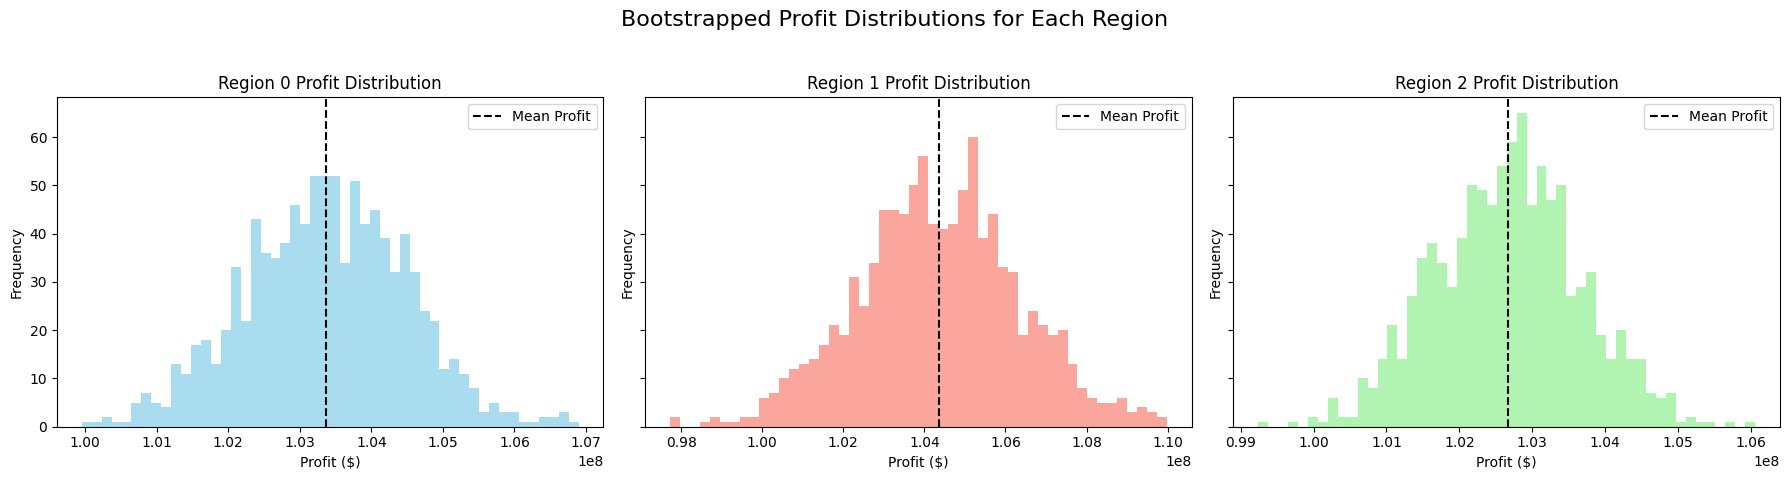

In [23]:
# visualization of profit distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = ['skyblue', 'salmon', 'lightgreen']

for i in range(3):
    axs[i].hist(profit_samples[i], bins=50, color=colors[i], alpha=0.7)
    axs[i].axvline(np.mean(profit_samples[i]), color='black', linestyle='dashed', linewidth=1.5, label='Mean Profit')
    axs[i].set_title(f'Region {i} Profit Distribution')
    axs[i].set_xlabel('Profit ($)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

plt.suptitle('Bootstrapped Profit Distributions for Each Region', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Step 6: Final Recommendation

- All regions meet the risk requirement (<2.5%).  
- **Region 1** has the highest mean profit (4.4M) with a 1.8% risk of losses.
- Regions 0 and 2 are the saffest with a risk of loss 0.03% and mean profit of (2-3M)
- Recommendation: Develop the top 200 wells in **Region 1**.  
- Justification: Region 1 has the highest expected profit and the risk of losses is below the 2.5% threshold. Although Regions 0 and 2 are slightly safer, they yield lower profits. For these reasons I beleve Region 1 to be the best choice